In [1]:
import pandas as pd
import numpy as np
import pickle
import re


from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class Data:
    """
    Load the data categorize the columns to categorical and numerical
    """
    def __init__(self, filepath: str = None, targetcol: str = None):
        self.data = pd.read_csv(filepath)
        aaa = self.data.isna().sum()
        self.data = self.data.drop(list(aaa[aaa>0].index),axis=1)
        self.targetcol = targetcol

    def get_numericals(self):
        self.num_cols = list(self.data.dtypes[
            (self.data.dtypes == 'int64') | (self.data.dtypes == 'float64')| 
            (self.data.dtypes == 'int32') | (self.data.dtypes == 'float32')|
            (self.data.dtypes == 'int16') | (self.data.dtypes == 'float16')|
            (self.data.dtypes == 'int8')].keys())
        if self.targetcol in self.num_cols:
            self.num_cols.remove(self.targetcol)
        self.cat_cols = list(set(self.data.columns).difference(self.num_cols))
        if self.targetcol in self.cat_cols:
            self.cat_cols.remove(self.targetcol)
        return self.num_cols, self.cat_cols

    def get_inputs(self):
        num_cols, cat_cols = self.get_numericals()
        return num_cols, self.targetcol, self.data, cat_cols

In [3]:
def bootstrap_confidence_lasso_ridge_(model, n_iterations, data, targetcol,num_cols, cat_cols):
    """
    get confidence score of the model using bootstrapping.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
        n_iterations: number of iteration to run bootstrapping
    return:
        Confidence interval: Lower and upper quantile.
    """
    try:
        scores = []
        mae = []
        for i in range(n_iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[num_cols+cat_cols], data[targetcol], test_size=0.2,random_state=i)
            X_train = X_train.fillna(X_train.median())
            X_test = X_test.fillna(X_train.median())
            model = model.fit(X_train, y_train)
            scores.append(model.score(X_test,y_test))
            mae.append(mean_absolute_error(model.predict(X_test), y_test))
        lower_mae, upper_mae = np.quantile(mae, q = 0.025), np.quantile(mae, q = 0.975)
        lower_score, upper_score = np.quantile(scores, q = 0.025), np.quantile(scores, q = 0.975)
        
        return lower_score, upper_score, lower_mae, upper_mae
    except:
        print("\n Not enough resampled data test data may have some new categories.")
        return 0,0

In [4]:
def fit_lasso_model(X_train:pd.DataFrame=None, y_train:pd.DataFrame=None):
    """
    Train a Lasso Model with cross validation having many different alpha parameters.
    L(β) = sum (yi − hat_yi)^2 + lambda * sum |beta_j|
    This function is not differentiable in its parameters. Hence there is no closed form of the estimator.
    
    args:
        X_train: training data dataframe
        y_train: Series of train target actual values
    return:
        ridge_model:
        alpha_: best alpha
        explanation: 2D sorted numpy array with (features, features coefficients) 
    """
    lasso_model = LassoCV(cv=10, alphas=[1e-3, 1e-2, 1e-1, 1, 10, 20]).fit(X_train, y_train)
    train_predictions = lasso_model.predict(X_train)
    train_r2 = lasso_model.score(X_train,y_train)
    print("Best Regularization Constant chosen by Lasso model:", lasso_model.alpha_)
    print("Lasso Training Model Score:", train_r2)
    feat_selected = list(X_train.columns[lasso_model.coef_.nonzero()])
    explanation = np.append(np.array(feat_selected).reshape(-1,1),
                                             lasso_model.coef_[lasso_model.coef_.nonzero()].reshape(-1,1).astype('float'),1)
    explanation[:,1] = np.abs(explanation[:,1].astype(np.float64))#.round(2)
    explanation = explanation[explanation[:,1].argsort()]
    hyperparameters = {'alpha':lasso_model.alpha_}
    return lasso_model, hyperparameters, train_predictions, train_r2, explanation

def fit_ridge_model(X_train:pd.DataFrame=None, y_train:pd.DataFrame=None):
    """
    Train a Ridge L2 regularization Model with cross validation having many different alpha parameters.
    L(β) = sum (yi − hat_yi)^2 + lambda * sum beta_j^2
    This function is differentiable in its parameters. Closed form of the estimator:
    beta = ((X^T)X + lambda I)^-1 (X.T)y
    
    args:
        X_train: training data dataframe
        y_train: Series of train target actual values
    return:
        ridge_model:
        alpha_: best alpha
        explanation: 2D sorted numpy array with (features, features coefficients)
    """
    ridge_model = RidgeCV(cv=10, alphas=[1e-3, 1e-2, 1e-1, 1, 10, 20]).fit(X_train, y_train)
    train_predictions = ridge_model.predict(X_train)
    train_r2 = ridge_model.score(X_train,y_train)
    print("Best Regularization Constant chosen by Ridge model:", ridge_model.alpha_)
    print("Ridge Training Model Score:", train_r2)
    feat_selected = list(X_train.columns[ridge_model.coef_.nonzero()])
    explanation = np.append(np.array(feat_selected).reshape(-1,1),
                                             ridge_model.coef_[ridge_model.coef_.nonzero()].reshape(-1,1),1)
    explanation[:,1] = np.abs(explanation[:,1].astype(np.float64))#.round(2)
    explanation = explanation[explanation[:,1].argsort()]
    hyperparameters = {'alpha':ridge_model.alpha_}
    return ridge_model, hyperparameters, train_predictions, train_r2, explanation

def predict_and_evaluate(model, X_test:pd.DataFrame=None, y_test:pd.DataFrame=None):
    """
    Do prediction using the model and then calculate the R2
    args:
        model: fitted model object
        X_test: DataFrame of Test data samples
        y_test: Series of test target actual values
    return:
        predictions: array of test predictions
        test_r2: R2 for test data    
    """
    predictions = model.predict(X_test)
    test_r2 = model.score(X_test, y_test)
    test_mse = mean_squared_error(y_test, predictions)
    return predictions, test_r2, test_mse

def predict_unknown(model, X_test:pd.DataFrame=None):
    """
    Do prediction using the model and then calculate the R2
    args:
        model: fitted model object
        X_test: DataFrame of Test data samples
    return:
        predictions: array of test predictions
    """
    predictions = model.predict(X_test)
    return predictions

In [5]:
### Fit model
##1. Get Train Predictions DOne
# 2. test predictions Done
# 3. Train and test R2 Done
# 4. Explanation Done
# 5. Confidence interval Done
# 6. Uncertainty ????? Prediction Interval

Index(['t_0_sum_prev', 't_0_std_prev', 't_0_max_prev', 't_0_min_prev',
       't_1_sum_prev', 't_1_std_prev', 't_1_median_prev', 't_1_max_prev',
       't_1_min_prev', 't_2_sum_prev', 't_2_std_prev', 't_2_max_prev',
       't_2_min_prev', 't_3_sum_prev', 't_3_std_prev', 't_3_max_prev',
       't_3_min_prev', 't_4_sum_prev', 't_4_std_prev', 't_4_max_prev',
       't_4_min_prev', 'num_0_sum', 'num_1_sum', 'num_2_sum', 't_0_sum',
       't_0_std', 't_0_max', 't_0_min', 't_1_sum', 't_1_std', 't_1_median',
       't_1_max', 't_1_min', 't_2_sum', 't_2_std', 't_2_max', 't_2_min',
       't_3_sum', 't_3_std', 't_3_max', 't_3_min', 't_4_sum', 't_4_std',
       't_4_max', 't_4_min', 'cat_0_max', 'cat_1_max', 'cat_2_max',
       'cat_3_max', 'cat_4_max', 'y_1', 'timediff'],
      dtype='object')
Best Regularization Constant chosen by Ridge model: 20.0
Ridge Training Model Score: 0.7051409344359267
ridge_test_r2:0.7157153651490108
ridge_test_r2:59.39381109407897
CI R2:(0.7065169688749484, 0.715479

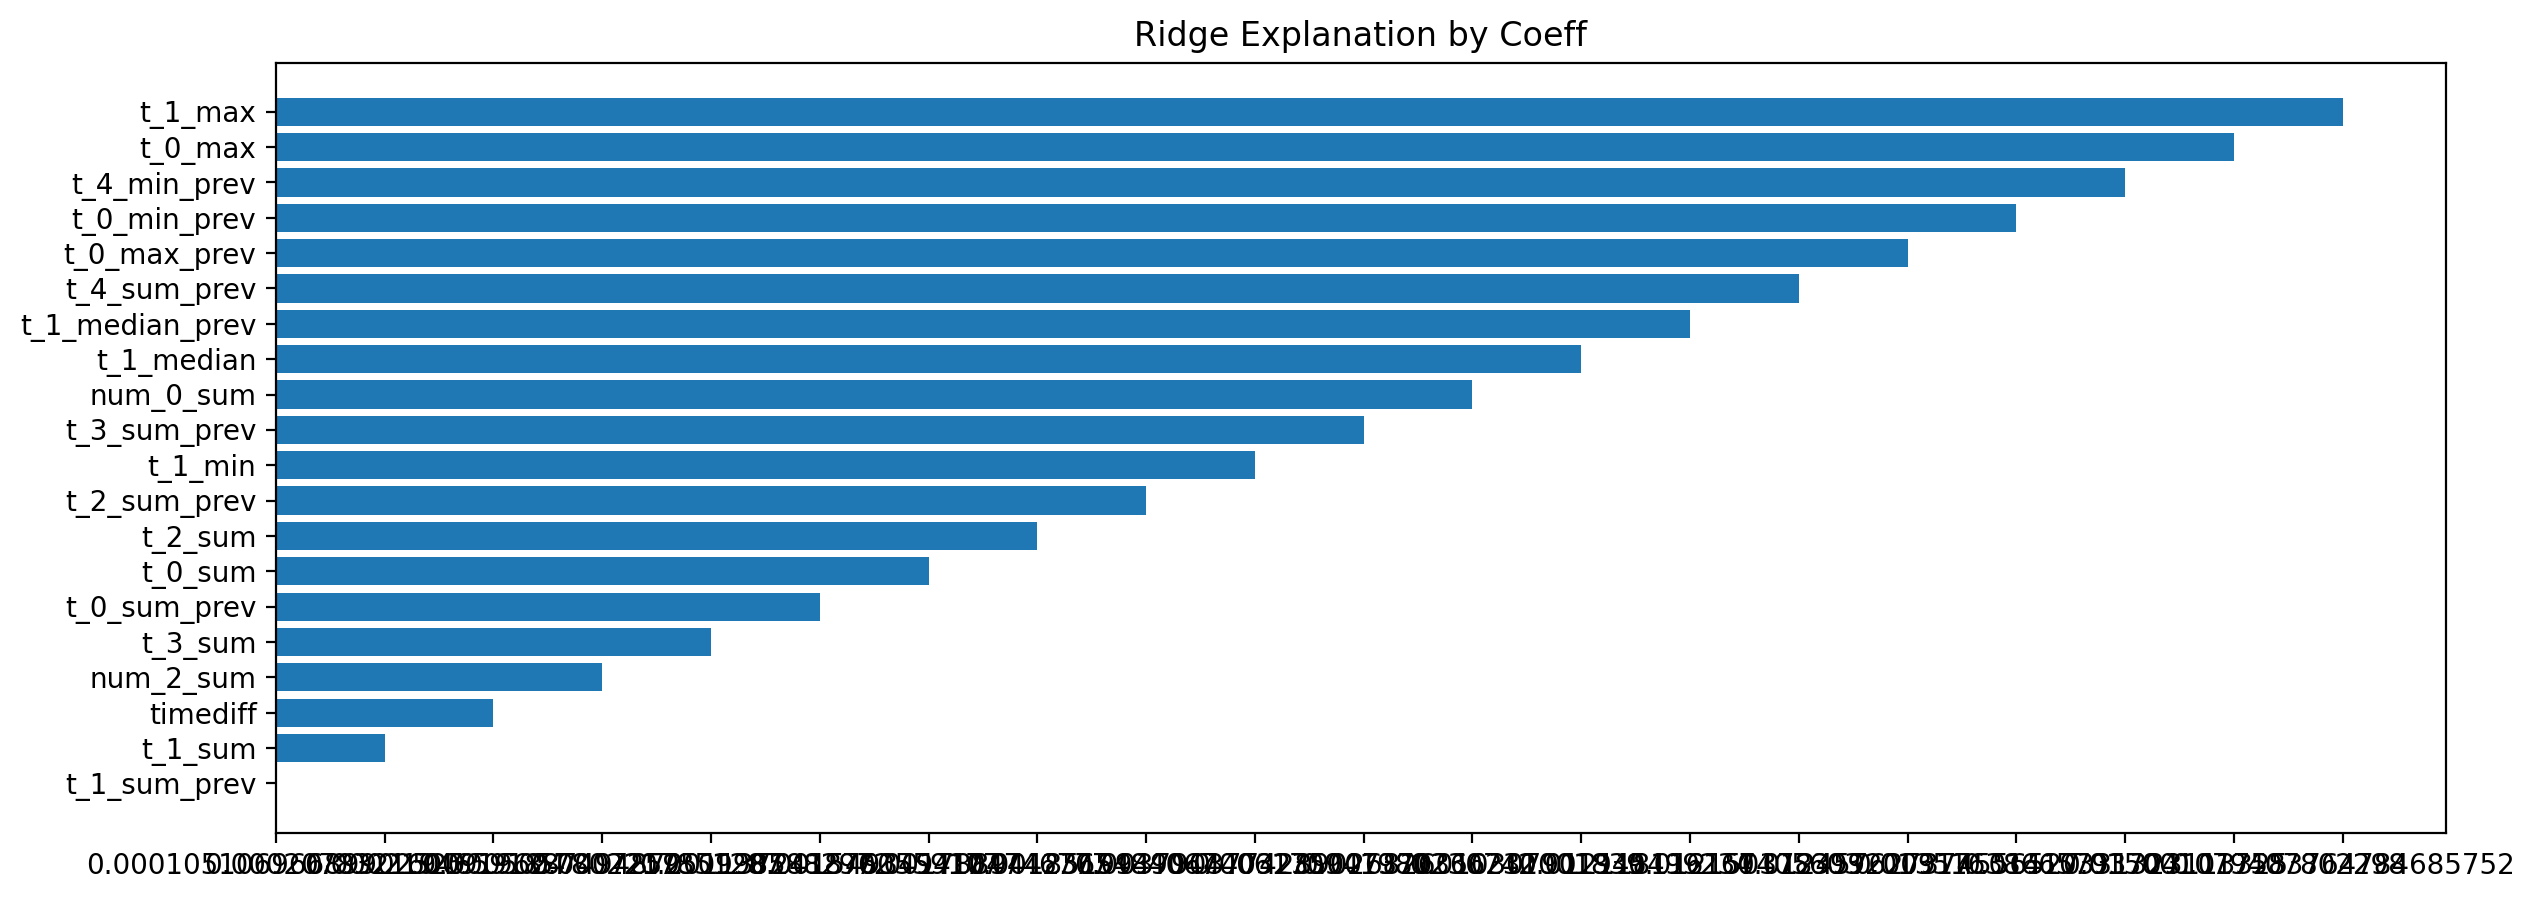

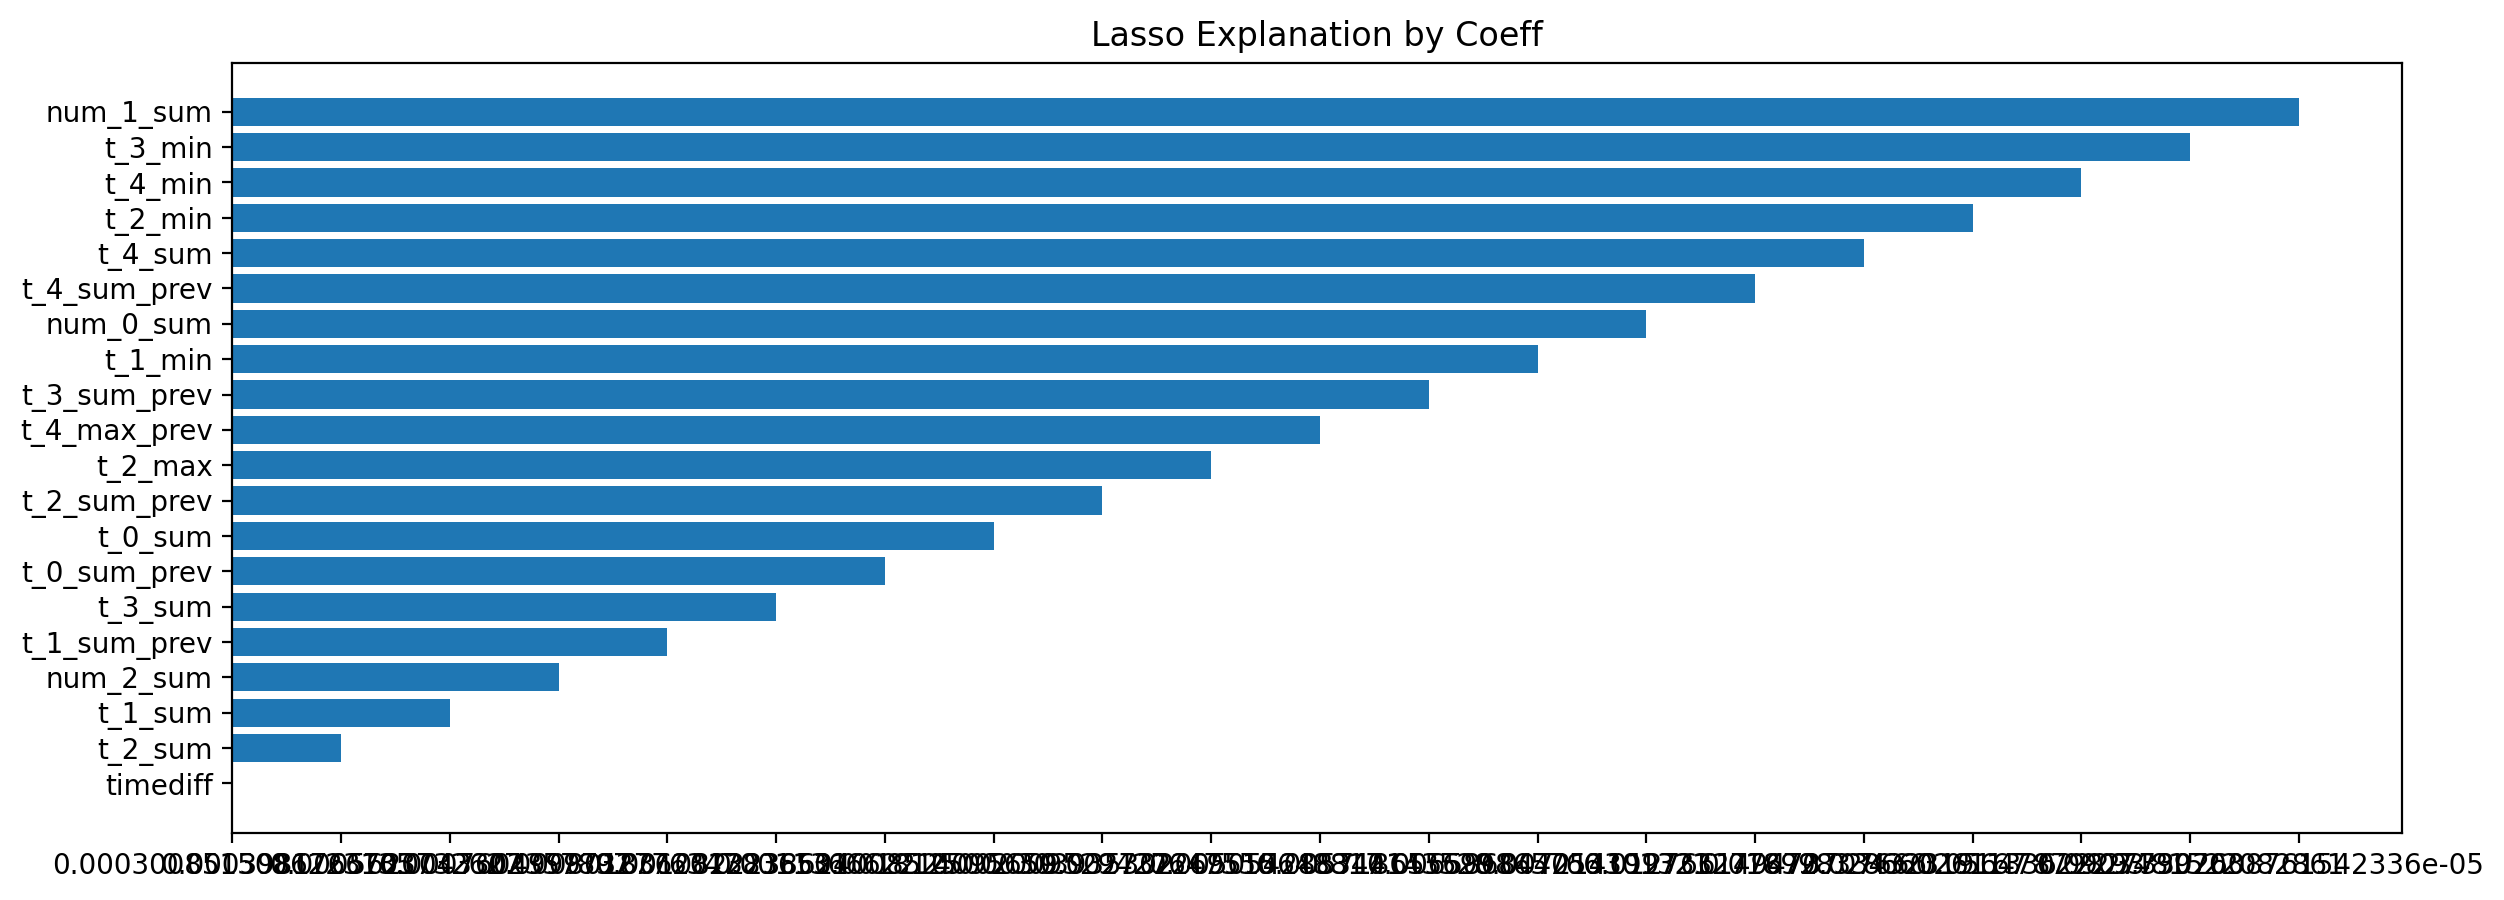

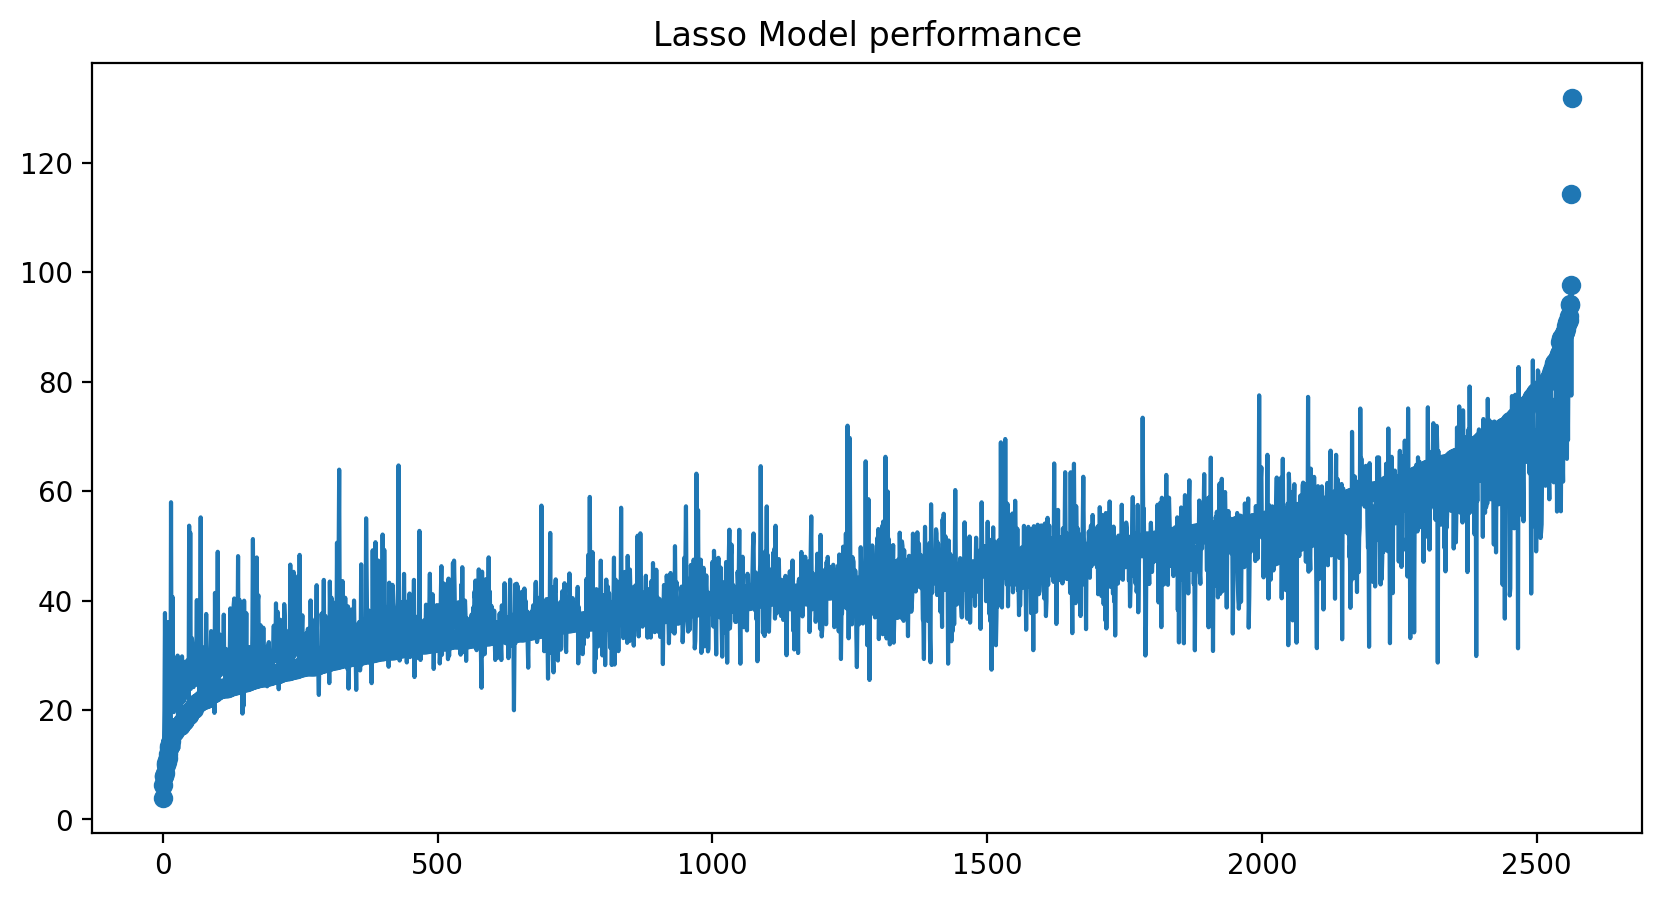

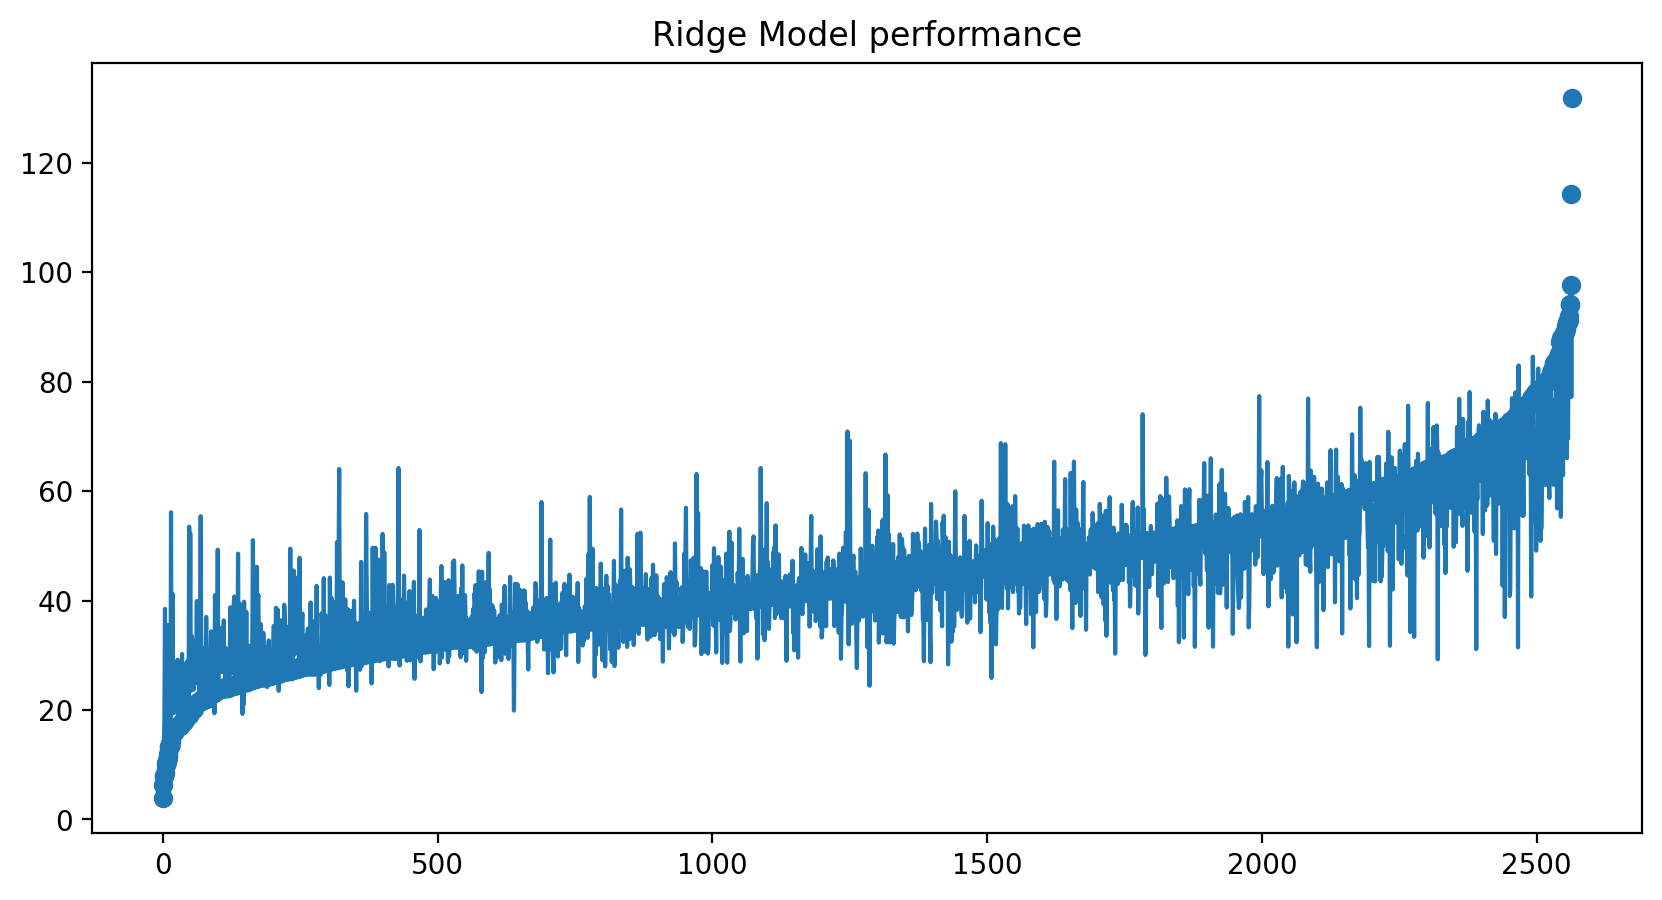

In [14]:
if __name__ == '__main__':
    data_obj = Data("/Users/lingrajsvannur/Documents/DataCompetition/first_rec_pat_train_y1.csv","y_1")
    num_cols, targetcol, data, cat_cols = data_obj.get_inputs()
    print(data.columns)
    #data = data.fillna(data.median())
    X_train, X_test, y_train, y_test = train_test_split(data[num_cols+cat_cols], data[targetcol], test_size=0.2, random_state=0)

    ridge_model, hyperparameters, ridge_train_predictions, ridge_train_r2, ridge_explanation = fit_ridge_model(X_train, y_train)
    ridge_predictions, ridge_test_r2, ridge_test_mse = predict_and_evaluate(ridge_model, X_test, y_test)
    print(f"ridge_test_r2:{ridge_test_r2}")
    print(f"ridge_test_r2:{ridge_test_mse}")

    lower_score, upper_score, lower_mae, upper_mae = bootstrap_confidence_lasso_ridge_(ridge_model, 2, data, targetcol,num_cols, cat_cols)
    print(f"CI R2:{lower_score,upper_score}\n")
    print(f"CI MAE:{lower_mae,upper_mae}\n")

    lasso_model, hyperparameters, lasso_train_predictions, lasso_train_r2, lasso_explanation = fit_lasso_model(X_train, y_train)
    lasso_predictions, lasso_test_r2, lasso_test_mse = predict_and_evaluate(lasso_model, X_test, y_test)
    print(f"lasso_test_r2:{lasso_test_r2}")
    print(f"lasso_test_mse:{lasso_test_mse}")

    lower_score, upper_score, lower_mae, upper_mae = bootstrap_confidence_lasso_ridge_(lasso_model, 2, data,targetcol,num_cols, cat_cols)
    print(f"CI R2:{lower_score,upper_mae}")
    print(f"CI MAE:{lower_mae,upper_mae}")
    
    lasso_model_performance = np.append(np.array(lasso_predictions).reshape(-1,1), np.array(y_test).reshape(-1,1),1)
    lasso_model_performance = lasso_model_performance[lasso_model_performance[:,1].argsort()]
    
    ridge_model_performance = np.append(np.array(ridge_predictions).reshape(-1,1), np.array(y_test).reshape(-1,1),1)
    ridge_model_performance = ridge_model_performance[ridge_model_performance[:,1].argsort()]
    
    filename = 'lasso_model.pkl'
    pickle.dump(lasso_model, open(filename, 'wb'))
    lasso_model = pickle.load(open(filename, 'rb'))

    filename = 'ridge_model.pkl'
    pickle.dump(ridge_model, open(filename, 'wb'))
    ridge_model = pickle.load(open(filename, 'rb'))
    
    fig, ax = plt.subplots(figsize=(14,5))
    plt.barh(ridge_explanation[:,0][:20],ridge_explanation[:,1][:20])
    plt.title('Ridge Explanation by Coeff')
    plt.show()
    fig, ax = plt.subplots(figsize=(14,5))
    plt.barh(lasso_explanation[:,0][-20:],lasso_explanation[:,1][-20:])
    plt.title('Lasso Explanation by Coeff')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(np.arange(len(lasso_model_performance)),lasso_model_performance[:,0])
    plt.scatter(np.arange(len(lasso_model_performance)),lasso_model_performance[:,1])
    plt.title('Lasso Model performance')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(np.arange(len(ridge_model_performance)),ridge_model_performance[:,0])
    plt.scatter(np.arange(len(ridge_model_performance)),ridge_model_performance[:,1])
    plt.title('Ridge Model performance')
    plt.show()

In [7]:
lasso_model

LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10, 20], cv=10)

In [8]:
lasso_model.predict(np.array(data.loc[0:5])[:,:-1])

array([99.22954431, 91.8989513 , 86.7473639 , 86.74304326, 87.10404479,
       85.82929735])

In [13]:
data.columns

Index(['t_0_sum_prev', 't_0_std_prev', 't_0_max_prev', 't_0_min_prev',
       't_1_sum_prev', 't_1_std_prev', 't_1_median_prev', 't_1_max_prev',
       't_1_min_prev', 't_2_sum_prev', 't_2_std_prev', 't_2_max_prev',
       't_2_min_prev', 't_3_sum_prev', 't_3_std_prev', 't_3_max_prev',
       't_3_min_prev', 't_4_sum_prev', 't_4_std_prev', 't_4_max_prev',
       't_4_min_prev', 'num_0_sum', 'num_1_sum', 'num_2_sum', 't_0_sum',
       't_0_std', 't_0_max', 't_0_min', 't_1_sum', 't_1_std', 't_1_median',
       't_1_max', 't_1_min', 't_2_sum', 't_2_std', 't_2_max', 't_2_min',
       't_3_sum', 't_3_std', 't_3_max', 't_3_min', 't_4_sum', 't_4_std',
       't_4_max', 't_4_min', 'cat_0_max', 'cat_1_max', 'cat_2_max',
       'cat_3_max', 'cat_4_max', 'y_1', 'timediff'],
      dtype='object')

In [10]:
np.array(data.loc[0:5])[:,:-1][0].shape

(51,)

In [11]:
import pandas as pd
import numpy as np
import os

from mordred import Calculator, descriptors
from rdkit import Chem

import warnings
warnings.filterwarnings("ignore") 

def All_Mordred_descriptors(calc, drugs, descriptors_list):
    """
    Calculate all Mordred Descriptors
    return:
        df: dataframe input X
        dropping_indices: indices of rows to be dropped in both X and Y
    """
    mols = []
    dropping_indices = []
    for i in range(len(drugs)):
        try:
            mol = Chem.MolFromSmiles(drugs[i])
            mols.append(mol)
        except:
            count += 1
            dropping_indices.append(i)
    calc_desc = list(calc.map(mols))
    calc_desc = [np.array(i.fill_missing(np.nan)) for i in calc_desc]
    df = pd.DataFrame(calc_desc, columns=descriptors_list)
    df = df.fillna(df.median())
    return df, dropping_indices

In [18]:
calc = Calculator(descriptors, ignore_3D=False)
descriptors_list = [str(i).split('.')[-1] for i in list(calc.descriptors)]
drugs = ["CCCCNBr", "Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2","C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C",
        "COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2)N(C)CC[C@]314"]
print("Number of drugs before:", len(drugs))

mordred_descpt, dropping_indices = All_Mordred_descriptors(calc, drugs, descriptors_list)

print(f"Leftover compounds:, {len(drugs)}")

Number of drugs before: 4


100%|███████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Leftover compounds:, 4


In [19]:
features_proppred = list(data.columns)[:-1]
aaa = mordred_descpt.isna().sum()
mordred_descpt = mordred_descpt[features_proppred]
mordred_descpt = mordred_descpt.fillna(0)

In [20]:
mordred_descpt

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,3.535534,3.869735,0.0,0.0,6.987918,1.801938,3.603875,6.987918,1.164653,2.579830,...,6.608001,28.105124,150.999661,9.437479,35.0,3.0,18.0,16.0,3.000000,1.750000
1,16.608204,13.337924,0.0,0.0,26.699543,2.464348,4.928696,26.699543,1.271407,3.987288,...,10.119687,55.366244,290.079038,8.287973,894.0,36.0,114.0,136.0,7.750000,4.472222
2,12.348985,10.563530,0.0,0.0,21.419186,2.071376,4.142753,21.419186,1.189955,3.712738,...,8.553525,47.915348,245.177964,5.979950,899.0,16.0,70.0,69.0,7.222222,4.500000
3,18.176087,13.966833,0.0,1.0,29.861283,2.708098,5.327071,29.861283,1.357331,4.095856,...,10.708467,72.649455,299.152144,6.957027,824.0,51.0,136.0,178.0,6.312500,4.625000


In [21]:
lasso_model.predict(mordred_descpt)

array([-3.62356422, -5.97185775, -4.39630867, -4.93174693])

In [22]:
ridge_model.predict(mordred_descpt)

array([-3.55494797, -6.07241643, -4.33629383, -4.97738482])